# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
import os
if not 'picost' in os.getcwd():
    data_dir = './processed_celeba_small/'
else:
    data_dir = '/data/picost/ml_samples/processed_celeba_small/'
print('Samples located in [{}]'.format(data_dir))

Samples located in [./processed_celeba_small/]


In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
import torchvision

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    
    Args:
    -----
    
        batch_size (int): 
            The size of each batch; the number of images in a batch
        img_size (int): 
            The square size of the image data (x, y)
        data_dir (str, optional): 
            Directory where image data is located. Default assumes local
            'processed_celeba_small/' directory.
    
    Return:
    -------
    
        DataLoader with batched data
    
    """
    transforms = torchvision.transforms.Compose(
        [torchvision.transforms.Resize(image_size), 
         torchvision.transforms.RandomHorizontalFlip(), 
         torchvision.transforms.ToTensor(), 
         #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
         ])
    img_set = torchvision.datasets.ImageFolder(root=data_dir, transform=transforms)
    loader = torch.utils.data.DataLoader(img_set, batch_size=batch_size, shuffle=True)
    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size, data_dir)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

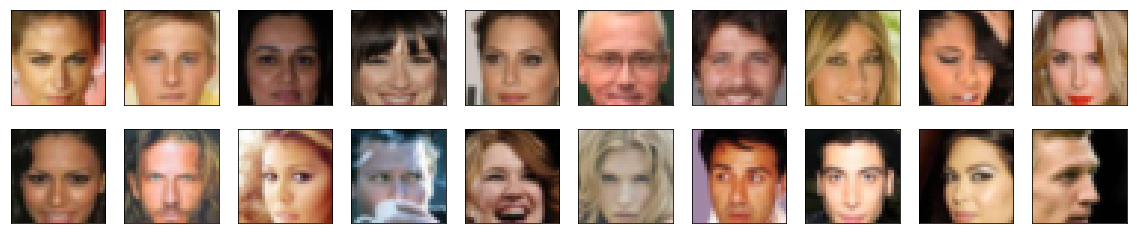

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Returns image scaled with a feature_range of pixel from -1 to 1. 
    
    Args:
    -----
    
        x (tensor like): 
            image to be scaled.
        feature_range (tuple, optional): 
            min and max values of new feature scale. Default is (-1, 1)
            
    Returns:
    --------
    
        Tensor:
            Copy of original tensor with scaled values
    
    
    .. note:
    
        This function assumes that the input x is already scaled from 0-1.
        
    '''
    return 2.*x - 1.


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9451)
Max:  tensor(0.9373)


In [9]:
img.max()

tensor(0.9686)

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


### Discriminator structure

The first attemt of discriminator defined for this GAN was build in a similar way as the one in the cycle-GAN project (itself inspired by the DCGAN and Cycle-GAN papers).

It is a succession of convolutional layers with the following caracteristics:
- Almost all layers use kernels with size 4 and stride 2 which downsample the features after each layer, while increasing the depth with a factor 2. 
- The first layer increases the depth of the input from 3 channels to a parameterized depth.
- All "internal" layers use batch normalization. (It has been shown)(https://arxiv.org/pdf/1512.03385.pdf) that this eases optimization of the weight (and reduce overfitting which in this  case could be the generator "learning by heart" the sample images).
- The number of internal layers is set to 2 (for a total of 4). This is one layer less than used in the cycle-GAN exercise due to the lower image size.
- The first and last layers do not use batch normalization, to comply with the findings in [the original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf).
- All activation functions are ReLU. In the cycle-GAN exercise, this was benchmarked vs leaky ReLU with negative slope of 0.2 and provided better results.
- The last layer is built using a size-conservative kernel (size 3, padding 1, stride 1) shrinking the features to a single channel which values are finally averaged.

The particular structure for the last layer was motivated by the following observation. In the cycle-GAN solution, there was what seemed to be a mistake: the last layer of the discriminator returned a 7x7 feature map. (as reported [here](https://github.com/udacity/deep-learning-v2-pytorch/issues/72) for example)
These feature map was then compared using MSE to a feature map of all 1 (resp. all 0) for the real images.
Changing this behaviour to use a kernel with same size as the former-last feature map to shrink it to only one value (mathematically equivalent to using a linear classifier over the flattened feature) ended-up in a result with lower quality.
This result was also reported by another student, as can be seen [here](https://knowledge.udacity.com/questions/29841).

As the project unit-tests did not allow the discriminator to return values which were not a scalar, a compromise was attempted:
 - the last layer uses a size-conservative kernel
 - the output of this layer is averaged to produce the final output

Combining this with a Mean-Squared-Error (MSE) is not exactly the same as using MSE directly on the last layer output as done in the cycle-CGAN exercise:
- MSE on all outputs of the last layer:
\begin{equation}
        MSE_{real} = \frac{1}{n_{\text{batch}} \times n_{\text{features}}}\sum_{i=1}^{n_{\text{batch}}}\sum_{j=1}^{n_{\text{features}}}(1 - d_{i,j})^2
\end{equation}
- MSE on averaged outputs of the last layer:
\begin{equation}
        MSE_{real} = \frac{1}{n_{\text{batch}}}\sum_{i=1}^{n_{\text{batch}}}(1 - ( \frac{1}{n_{\text{features}}} \sum_{j=1}^{n_{\text{features}}}d_{i,j}))^2
\end{equation}
The later looks a little less favorable to the optimization due do the cross correlation terms between output features appearing in the error formulation.

It is however used in a first attempt in order to compare it VS. a direct one dimensional output.

In [10]:
from gan_maker.discriminators.cnn_with_average import Discriminator

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
from gan_maker.generators.default_generator import Generator

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    
    Args:
    -----
    
        m: 
            A module or layer in a network   
            
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if 'Linear' in classname or 'Conv2d' in classname:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 0.02)
        try:
            m.bias.data.fill_(0.)
        except AttributeError:
            pass   
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_classify): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

Generator(
  (fc_in): Linear(in_features=50, out_features=4096, bias=True)
  (dconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
#Not using MSELoss so we do not need to create a tensor of ones/zeros each time

def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out - 1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out ** 2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

*Reuse the parameters identified in the exercises (which were taken from the DCGAN paper).*

In [17]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=200):
    """Trains adversarial networks for some number of epochs
    
    Args:
    -----
    
        D (nn.Module): 
            Discriminator network
        G (nn.Module):
            Generator network
        n_epochs (int): 
            number of epochs to train for
        print_every (int, optional): 
            period at which the models' losses ar eprinted to console
            
    Returns:
    --------
        
        list : 
            tuples of D and G losses at each epoch
            
    .. note:
    
        The function optimizes the weights of passed D and G as side-effect.
            
    """
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    # epoch training loop
    for epoch in range(n_epochs):
        # batch training loop
        batch_losses = np.empty((len(celeba_train_loader), 2))
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            batch_size = real_images.size(0)
            real_images = scale(real_images)
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            D.train()
            G.train()
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            random_z = np.random.uniform(-1., 1., size=(batch_size, z_size))
            random_z = torch.from_numpy(random_z).float()
            if train_on_gpu:
                random_z = random_z.cuda()
                real_images = real_images.cuda()
            # Discriminate real images
            d_loss_real = real_loss(D(real_images))
            # Discriminate fake images
            fake_images = G(random_z)
            d_loss_fake = fake_loss(fake_images)
            # Assemble loss and update
            d_loss = d_loss_fake + d_loss_real
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            random_z = np.random.uniform(-1., 1., size=(batch_size, z_size))
            random_z = torch.from_numpy(random_z).float()
            # move z to GPU if available
            if train_on_gpu:
                random_z = random_z.cuda()
            fake_generated = G(random_z)
            g_loss = real_loss(D(fake_generated))
            g_loss.backward()
            g_optimizer.step()
            batch_losses[batch_i, :] = [d_loss.item(), g_loss.item()]
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================
            # Print some loss stats
            if batch_i % print_every == 0:
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d} - batch{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, batch_i, d_loss.item(), g_loss.item()))
        ## AFTER EACH EPOCH##   
        # append discriminator loss and generator loss
        losses.append(batch_losses.sum(axis=0))
        print('-' * 70)
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
        print('-' * 70)
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    # finally return losses
    D.eval()
    G.eval()
    losses = np.array(losses)
    return losses

Set your number of training epochs and train your GAN!

In [ ]:
# set number of epochs 
n_epochs = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50 - batch    0] | d_loss: 28.6331 | g_loss: 48.2888
Epoch [    1/   50 - batch  200] | d_loss: 0.2427 | g_loss: 0.0461
Epoch [    1/   50 - batch  400] | d_loss: 0.0326 | g_loss: 0.0033
Epoch [    1/   50 - batch  600] | d_loss: 0.0266 | g_loss: 0.0009
Epoch [    1/   50 - batch  800] | d_loss: 0.0238 | g_loss: 0.0009
Epoch [    1/   50 - batch 1000] | d_loss: 0.0224 | g_loss: 0.0008
Epoch [    1/   50 - batch 1200] | d_loss: 0.0223 | g_loss: 0.0005
Epoch [    1/   50 - batch 1400] | d_loss: 0.0214 | g_loss: 0.0002
----------------------------------------------------------------------
Epoch [    1/   50] | d_loss: 0.0198 | g_loss: 0.0006
----------------------------------------------------------------------
Epoch [    2/   50 - batch    0] | d_loss: 0.0208 | g_loss: 0.0002
Epoch [    2/   50 - batch  200] | d_loss: 0.0196 | g_loss: 0.0002
Epoch [    2/   50 - batch  400] | d_loss: 0.0183 | g_loss: 0.0001
Epoch [    2/   50 - batch  600] | d_loss: 0.0192 | g_loss: 0.000

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
plt.plot(losses[:, 0], label='Discriminator', alpha=0.5)
plt.plot(losses[:, 1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.